# Predictive Analysis

### 1. Import libraries and data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVC, SVR
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from functions import clean_column_names, Classifier_calculate_metrics_FINAL2, load_and_prepare_data, select_features_by_pearson, select_features_by_anova, get_dataframe_with_selected_features

X, y = load_and_prepare_data()
X.head()

,dd0 Cell Density,dd0-dd1 Cell Density Gradient,dd1 Cell Density,dd1-dd2 Cell Density Gradient,dd2 Cell Density,dd2-dd3 Cell Density Gradient,dd3 Cell Density,dd3-dd5 Cell Density Gradient,dd5 Cell Density,dd5-dd7 Cell Density Gradient,...,dd1 Lactate Concentration,dd3 Lactate Concentration,dd5 Lactate Concentration,dd7 Lactate Concentration,dd0 Glucose Concentration,dd1 Glucose Concentration,dd3 Glucose Concentration,dd5 Glucose Concentration,dd7 Glucose Concentration,y
0,0.725,0.213793,0.88,0.19007,1.047261,-0.040354,1.005,0.810945,1.820,-0.144394,...,14.025,2.090,17.780,5.935,9.1800,3.895,9.8750,0.635,7.555,75.7
1,0.650,0.384615,0.90,0.19007,1.071063,0.246426,1.335,0.749064,2.335,-0.144394,...,13.350,2.165,17.105,12.510,9.5200,4.470,10.1450,1.010,2.910,75.0
2,0.880,0.022727,0.90,0.19007,1.071063,-0.038338,1.030,0.611650,1.660,-0.144394,...,13.670,1.775,19.050,7.210,9.0275,4.415,10.2700,0.000,6.745,55.6
3,0.785,0.363057,1.07,0.19007,1.273374,-0.462059,0.685,0.510949,1.035,-0.144394,...,11.955,0.995,16.430,14.295,8.9950,5.155,10.2550,2.270,2.135,57.7
4,0.410,0.975610,0.81,0.19007,0.963956,1.778134,2.678,-0.002987,2.670,-0.376404,...,11.300,15.100,16.425,14.455,9.5475,1.700,0.0175,1.610,1.065,63.0


- Compute the percentage of sufficient experiences (for XGBoost)

In [2]:
num_sufficient_samples = X[X['y'] >= 90].shape[0]
num_insuff_samples = X.shape[0] - num_sufficient_samples

### 2. Feature selection using correlation coefficients

Feature Selection with correlation coefficients:

- Pearson: input var numerical, output var numerical (regression problem)
- ANOVA: input var numerical, output var categorical (classification problem)

In [3]:
# Pearson
print('Pearson correlation:')
cols_PearsonCorr = select_features_by_pearson(X)

# ANOVA
print('ANOVA correlation:')
cols_ANOVACorr = select_features_by_anova(X, y)

Pearson correlation:
Number of variables with p-value <= 0.005: 9
ANOVA correlation:
Number of variables with p-value <= 0.05: 15


### 3. Definition of feature sets

- Definition of datasets with selected features

In [4]:
# Feature set from study by Williams et al. (2020)
X_FS1_RF = get_dataframe_with_selected_features(X=X, feature_set_name='FS1_RF')

# Feature sets obtained with biclustering analysis
X_CCCB1 = get_dataframe_with_selected_features(X=X, feature_set_name='CCCB1')
X_CCCB1_1 = get_dataframe_with_selected_features(X=X, feature_set_name='CCCB1_1')

X_CCCB2 = get_dataframe_with_selected_features(X=X, feature_set_name='CCCB2')
X_CCCB2_1 = get_dataframe_with_selected_features(X=X, feature_set_name='CCCB2_1')

# Feature sets obtained with correlation coefficients
X_PearsonCorr = X[cols_PearsonCorr]
X_ANOVACorr = X[cols_ANOVACorr]

- Most selected features (across all feature sets)

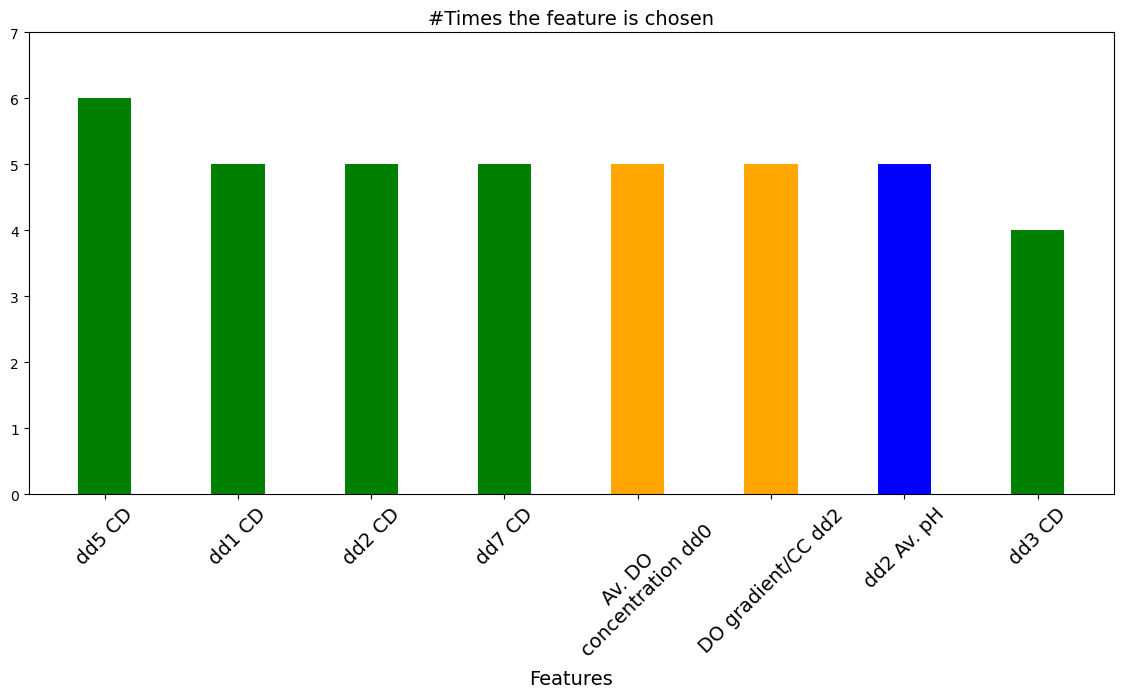

In [5]:
fig, ax = plt.subplots(figsize = (14,6))

features = ['dd5 CD', 'dd1 CD', 'dd2 CD', 'dd7 CD', 'Av. DO \n concentration dd0', 
            'DO gradient/CC dd2', 'dd2 Av. pH', 'dd3 CD']  
number_of_times_chosen = [6,5,5,5,5,5,5,4]
bar_colors = ['green', 'green', 'green', 'green', 'orange', 'orange', 'blue', 'green']

ax.bar(features, number_of_times_chosen, color=bar_colors,width=0.4)
ax.set_title('#Times the feature is chosen', fontsize = 14)
ax.set_xlabel('Features', fontsize =14)
ax.set_ylim(0,7)
ax.set_xticks(features)
ax.set_xticklabels(features, fontsize=14, rotation=45) 

plt.show()

### 4. Classification models

In [6]:
# Common for all classification models
cv1 = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv2 = LeaveOneOut()

CV_methods_list = [cv1, cv2]
CV_methods_strings_list = ['Stratified 10-Fold', 'Leave One Out']
CV_methods_strings = ['skfcv', 'loocv']

threshold_for_classification = 90
y1 = y.values.ravel()
y_class = y_class = np.where(y1 >= threshold_for_classification, 0, 1)

FSs = [X_FS1_RF, X_CCCB1, X_CCCB1_1, X_CCCB2, X_CCCB2_1, X_ANOVACorr]
FSs_strings = ['X_FS1_RF', 'X_CCCB1', 'X_CCCB1_1', 'X_CCCB2', 'X_CCCB2_1', 'X_ANOVACorr']

### 4.1. Gaussian Naive Bayes Classifier
- without SMOTE

In [7]:
AICs_LOO_GNB = []

print('Gaussian Naive Bayes Classifier Results')
print('Stratified 10-Fold')
for i in range(len(FSs)):
    print('Using the feature selection ', FSs_strings[i])
    (mean_metrics, std_metrics) = Classifier_calculate_metrics_FINAL2(model_str = 'GaussianNaiveBayesClassifier',
                                                                                X = FSs[i], 
                                                                                y = y_class,
                                                                                model_params={},
                                                                                cross_validation_technique = 'skfcv')
    print()

print('Leave One Out')
for i in range(len(FSs)):
    print('Using the feature selection ', FSs_strings[i])
    (metrics, stds) = Classifier_calculate_metrics_FINAL2(model_str = 'GaussianNaiveBayesClassifier',
                                                                                X = FSs[i], 
                                                                                y = y_class,
                                                                                model_params={},
                                                                                cross_validation_technique = 'loocv')
    AICs_LOO_GNB.append(metrics[5])
    print()

Gaussian Naive Bayes Classifier Results
Stratified 10-Fold
Using the feature selection  X_FS1_RF
Mean accuracy: 0.683 ± 0.203
Mean precision: 0.792 ± 0.180
Mean recall: 0.750 ± 0.224
Mean f1 score: 0.752 ± 0.166
Mean MCC score: 0.296 ± 0.468
Mean AIC score: 150.820 ± 55.398
Mean BIC score: 139.783 ± 55.398

Using the feature selection  X_CCCB1
Mean accuracy: 0.567 ± 0.153
Mean precision: 0.860 ± 0.215
Mean recall: 0.490 ± 0.161
Mean f1 score: 0.600 ± 0.145
Mean MCC score: 0.227 ± 0.399
Mean AIC score: 134.548 ± 26.593
Mean BIC score: 123.511 ± 26.593

Using the feature selection  X_CCCB1_1
Mean accuracy: 0.533 ± 0.180
Mean precision: 0.718 ± 0.214
Mean recall: 0.530 ± 0.182
Mean f1 score: 0.597 ± 0.171
Mean MCC score: 0.061 ± 0.398
Mean AIC score: 238.972 ± 44.409
Mean BIC score: 219.605 ± 44.409

Using the feature selection  X_CCCB2
Mean accuracy: 0.633 ± 0.208
Mean precision: 0.833 ± 0.211
Mean recall: 0.580 ± 0.200
Mean f1 score: 0.672 ± 0.188
Mean MCC score: 0.309 ± 0.448
Mean AIC 

- with SMOTE

In [9]:
AICs_LOO_SMOTE_GNB = []

print('SMOTE + Gaussian Naive Bayes Classifier Results')
print('Stratified 10-Fold')
for i in range(len(FSs)):
    print('Using the feature selection ', FSs_strings[i])
    (mean_metrics, std_metrics) = Classifier_calculate_metrics_FINAL2(model_str = 'SMOTE+GaussinNaiveBayesClassifier',
                                                                                X = FSs[i], 
                                                                                y = y_class,
                                                                                model_params={},
                                                                                cross_validation_technique = 'skfcv')
    print()

print('Leave One Out')
for i in range(len(FSs)):
    print('Using the feature selection ', FSs_strings[i])
    (metrics, stds) = Classifier_calculate_metrics_FINAL2(model_str = 'SMOTE+GaussinNaiveBayesClassifier',
                                                                                X = FSs[i], 
                                                                                y = y_class,
                                                                                model_params={},
                                                                                cross_validation_technique = 'loocv')
    AICs_LOO_SMOTE_GNB.append(metrics[5])
    print()

SMOTE + Gaussian Naive Bayes Classifier Results
Stratified 10-Fold
Using the feature selection  X_FS1_RF
Mean accuracy: 0.617 ± 0.183
Mean precision: 0.808 ± 0.217
Mean recall: 0.610 ± 0.197
Mean f1 score: 0.678 ± 0.163
Mean MCC score: 0.240 ± 0.410
Mean AIC score: 152.352 ± 56.511
Mean BIC score: 141.315 ± 56.511

Using the feature selection  X_CCCB1
Mean accuracy: 0.567 ± 0.153
Mean precision: 0.833 ± 0.211
Mean recall: 0.510 ± 0.116
Mean f1 score: 0.615 ± 0.127
Mean MCC score: 0.197 ± 0.408
Mean AIC score: 138.581 ± 27.101
Mean BIC score: 127.544 ± 27.101

Using the feature selection  X_CCCB1_1
Mean accuracy: 0.533 ± 0.208
Mean precision: 0.710 ± 0.236
Mean recall: 0.555 ± 0.193
Mean f1 score: 0.610 ± 0.184
Mean MCC score: 0.040 ± 0.459
Mean AIC score: 244.459 ± 45.584
Mean BIC score: 225.093 ± 45.584

Using the feature selection  X_CCCB2
Mean accuracy: 0.683 ± 0.174
Mean precision: 0.875 ± 0.172
Mean recall: 0.650 ± 0.200
Mean f1 score: 0.725 ± 0.147
Mean MCC score: 0.346 ± 0.402
M

### 4.2. Random Forest Classifier


In [10]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [3, 4, 5, 10, 50, 100, 200],
    'max_depth': [None, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 8, 10, 15, 20]
}

best_hyperparameters_RFC_list = []
model = RandomForestClassifier(random_state=42)

for j in range(len(CV_methods_list)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = CV_methods_list[j], scoring='accuracy')
        grid_search.fit(FSs[i], y_class)
        best_hyperparameters_RFC_list.append(grid_search.best_params_)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
        print()
    print()

###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8833

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.7833

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.7667

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8833

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 8, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9000

Using the feature selection  X_ANOVACorr :
Best Hyperparameters: {'max

In [11]:
AIC_LOO_RFC = []

for j in range(len(CV_methods_strings)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        print('Using the feature selection ', FSs_strings[i], ':')
        (mean_metrics, std_metrics) = Classifier_calculate_metrics_FINAL2(model_str = 'RandomForestClassifier',
                                                                                        X = FSs[i],
                                                                                        y = y_class,
                                                                                        model_params=best_hyperparameters_RFC_list[6*j+i],
                                                                                        cross_validation_technique = CV_methods_strings[j])
        if CV_methods_strings[j] == 'loocv':
            AIC_LOO_RFC.append(mean_metrics[5])
        print()
    print()

###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Mean accuracy: 0.883 ± 0.107
Mean precision: 0.900 ± 0.100
Mean recall: 0.950 ± 0.150
Mean f1 score: 0.911 ± 0.097
Mean MCC score: 0.766 ± 0.195
Mean AIC score: 3218.826 ± 86.313
Mean BIC score: 2884.163 ± 77.264

Using the feature selection  X_CCCB1 :
Mean accuracy: 0.783 ± 0.107
Mean precision: 0.795 ± 0.116
Mean recall: 0.950 ± 0.100
Mean f1 score: 0.856 ± 0.068
Mean MCC score: 0.449 ± 0.339
Mean AIC score: 566.768 ± 14.276
Mean BIC score: 508.461 ± 12.772

Using the feature selection  X_CCCB1_1 :
Mean accuracy: 0.767 ± 0.170
Mean precision: 0.783 ± 0.142
Mean recall: 0.900 ± 0.229
Mean f1 score: 0.823 ± 0.172
Mean MCC score: 0.462 ± 0.378
Mean AIC score: 1487.915 ± 37.021
Mean BIC score: 1333.651 ± 33.085

Using the feature selection  X_CCCB2 :
Mean accuracy: 0.883 ± 0.107
Mean precision: 0.895 ± 0.106
Mean recall: 0.950 ± 0.100
Mean f1 score: 0.916

### 4.3. XGBoost Classifier

In [12]:
scale_pos_weight_1 = num_insuff_samples/num_sufficient_samples

# Define hyperparameter grid
param_grid = {
    'n_estimators': [3, 4, 5, 10, 50, 100, 200],
    'max_depth': [None, 5, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'reg_lambda': [0,1],
    'scale_pos_weight': [1, scale_pos_weight_1]
}

best_hyperparameters_XGBC_list = []
model = XGBClassifier(random_state=42)

for j in range(len(CV_methods_list)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        # Clean feature names
        FSs[i] = clean_column_names(FSs[i])
        
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = CV_methods_list[j], scoring='accuracy')
        grid_search.fit(FSs[i], y_class)
        best_hyperparameters_XGBC_list.append(grid_search.best_params_)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
        print()
    print()

###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 0, 'scale_pos_weight': 2.1578947368421053}
Best Cross-Validation Accuracy: 0.8500

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 1, 'scale_pos_weight': 1}
Best Cross-Validation Accuracy: 0.7833

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 3, 'reg_lambda': 1, 'scale_pos_weight': 1}
Best Cross-Validation Accuracy: 0.8500

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 10, 'reg_lambda': 0, 'scale_pos_weight': 2.1578947368421053}
Best Cross-Validation Accuracy: 0.9000

Using the feature selection  X_CCCB2_1 :
Best Hyperpar

In [13]:
CV_methods_strings = ['skfcv', 'loocv']
AIC_LOO_XGBoost = []

for j in range(len(CV_methods_strings)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        print('Using the feature selection ', FSs_strings[i], ':')
        (mean_metrics, std_metrics) = Classifier_calculate_metrics_FINAL2(model_str = 'XGBoostClassifier',
                                                                                        X = FSs[i], 
                                                                                        y = y_class,
                                                                                        model_params=best_hyperparameters_XGBC_list[6*j+i],
                                                                                        cross_validation_technique = CV_methods_strings[j])
        print()
        if CV_methods_strings[j] == 'loocv':
            AIC_LOO_XGBoost.append(mean_metrics[5])
    print()

###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Mean accuracy: 0.850 ± 0.138
Mean precision: 0.840 ± 0.140
Mean recall: 1.000 ± 0.000
Mean f1 score: 0.907 ± 0.084
Mean MCC score: 0.590 ± 0.415
Mean AIC score: 2731.211 ± 341.928
Mean BIC score: 2447.420 ± 306.516

Using the feature selection  X_CCCB1 :
Mean accuracy: 0.783 ± 0.107
Mean precision: 0.843 ± 0.135
Mean recall: 0.880 ± 0.121
Mean f1 score: 0.848 ± 0.072
Mean MCC score: 0.481 ± 0.318
Mean AIC score: 869.286 ± 26.646
Mean BIC score: 779.493 ± 23.670

Using the feature selection  X_CCCB1_1 :
Mean accuracy: 0.850 ± 0.090
Mean precision: 0.867 ± 0.115
Mean recall: 0.950 ± 0.100
Mean f1 score: 0.896 ± 0.058
Mean MCC score: 0.658 ± 0.260
Mean AIC score: 64.913 ± 2.077
Mean BIC score: 58.791 ± 1.863

Using the feature selection  X_CCCB2 :
Mean accuracy: 0.900 ± 0.111
Mean precision: 0.907 ± 0.120
Mean recall: 0.975 ± 0.075
Mean f1 score: 0.932 ± 0

### 4.4. Support Vector Machine Classifier

- pipeline: (1) standard scaler, (2) SVM 

In [14]:
# Define hyperparameter grid
param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__kernel': ['linear','rbf'],
    'svc__gamma': [1, 0.1, 0.01, 0.001]
}

best_hyperparameters_SVMC_list = []

# Define scaler, model and pipeline
standard_scaler = StandardScaler()
model = SVC(random_state=42)
pipeline_SVMC = Pipeline([
    ('scaler', standard_scaler),
    ('svc', model)
])

print('Support Vector Machine Classifier, pipeline = scaler, SVC')
for j in range(len(CV_methods_list)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        
        grid_search = GridSearchCV(estimator=pipeline_SVMC, param_grid=param_grid, cv = CV_methods_list[j], scoring='accuracy')
        grid_search.fit(FSs[i], y_class)
        best_hyperparameters_SVMC_list.append(grid_search.best_params_)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
        print()
    print()

Support Vector Machine Classifier, pipeline = scaler, SVC
###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7167

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8000

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7333

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7833

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'linear'}
Best Cross-Validation Accuracy: 0.7000

Using the feature selection  X_ANOVACorr :
Best Hy

- pipeline: (1) SMOTE, (2) standard scaler, (3) SVM 

In [15]:
best_hyperparameters_SMOTE_SVMC_list = []

# Define smote, scaler, model and pipeline
SMOTE_SVM = SMOTE(random_state=42, k_neighbors=5)
standard_scaler = StandardScaler()
model = SVC(random_state=42)
pipeline_SMOTE_SVMC = Pipeline([
    ('smote', SMOTE_SVM),
    ('scaler', standard_scaler),
    ('svc', model)
])

print('Support Vector Machine Classifier, pipeline = SMOTE, scaler, SVC')
for j in range(len(CV_methods_list)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        
        grid_search = GridSearchCV(estimator=pipeline_SMOTE_SVMC, param_grid=param_grid, cv = CV_methods_list[j], scoring='accuracy')
        grid_search.fit(FSs[i], y_class)
        best_hyperparameters_SMOTE_SVMC_list.append(grid_search.best_params_)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
        print()
    print()

Support Vector Machine Classifier, pipeline = SMOTE, scaler, SVC
###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8167

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7667

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7167

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7333

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'linear'}
Best Cross-Validation Accuracy: 0.6833

Using the feature selection  X_ANOVACorr :


- Calculate the other classification evaluation metrics

In [16]:
AIC_LOO_SVM = []

# calculate the other classification metrics
print('Support Vector Machine Classifier, pipeline = Scaler, SVC')
for j in range(len(CV_methods_strings)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        print('Using the feature selection ', FSs_strings[i], ':')
        (mean_metrics, std_metrics) = Classifier_calculate_metrics_FINAL2(model_str = 'Scaler+SVMClassifier',
                                                                                        X = FSs[i], 
                                                                                        y = y_class,
                                                                                        model_params=best_hyperparameters_SVMC_list[6*j+i],
                                                                                        cross_validation_technique = CV_methods_strings[j])
        print()
        if CV_methods_strings[j] == 'loocv':
            AIC_LOO_SVM.append(mean_metrics[5])
    print()

Support Vector Machine Classifier, pipeline = Scaler, SVC
###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Mean accuracy: 0.717 ± 0.183
Mean precision: 0.738 ± 0.149
Mean recall: 0.925 ± 0.160
Mean f1 score: 0.814 ± 0.134
Mean MCC score: 0.238 ± 0.463
Mean AIC score: 98.647 ± 3.717
Mean BIC score: 89.173 ± 3.477

Using the feature selection  X_CCCB1 :
Mean accuracy: 0.800 ± 0.145
Mean precision: 0.820 ± 0.130
Mean recall: 0.925 ± 0.160
Mean f1 score: 0.858 ± 0.115
Mean MCC score: 0.524 ± 0.368
Mean AIC score: 73.210 ± 5.879
Mean BIC score: 66.359 ± 5.441

Using the feature selection  X_CCCB1_1 :
Mean accuracy: 0.733 ± 0.153
Mean precision: 0.775 ± 0.130
Mean recall: 0.880 ± 0.165
Mean f1 score: 0.814 ± 0.119
Mean MCC score: 0.346 ± 0.395
Mean AIC score: 76.903 ± 2.907
Mean BIC score: 69.678 ± 2.766

Using the feature selection  X_CCCB2 :
Mean accuracy: 0.783 ± 0.150
Mean precision: 0.813 ± 0.139
Mean 

### 4.5. Decision Tree Classifier

- Optimize hyperparameters

In [17]:
# Define the model
model = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid 
param_grid = {
    'max_depth': [None, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 8, 10, 15, 20]
}

best_hyperparameters_DTC_list = []

print('Decision Tree Classifier')
for j in range(len(CV_methods_list)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv = CV_methods_list[j], scoring='accuracy')
        grid_search.fit(FSs[i], y_class)
        best_hyperparameters_DTC_list.append(grid_search.best_params_)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
        print()
    print()

Decision Tree Classifier
###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Accuracy: 0.8500

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Accuracy: 0.6500

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Accuracy: 0.7833

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 10}
Best Cross-Validation Accuracy: 0.8833

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Accuracy: 0.8500

Using the feature selection  X_ANOVACorr :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Accuracy: 0.9

- Calculate other classification evaluation metrics

In [18]:
AIC_LOO_DT = []

print('Decision Tree Classifier')
for j in range(len(CV_methods_strings)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        print('Using the feature selection ', FSs_strings[i], ':')
        (mean_metrics, std_metrics) = Classifier_calculate_metrics_FINAL2(model_str = 'DecisionTreeClassifier',
                                                                                        X = FSs[i], 
                                                                                        y = y_class,
                                                                                        model_params=best_hyperparameters_DTC_list[6*j+i],
                                                                                        cross_validation_technique = CV_methods_strings[j])
        print()
        if CV_methods_strings[j] == 'loocv':
            AIC_LOO_DT.append(mean_metrics[5])
    print()

Decision Tree Classifier
###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Mean accuracy: 0.850 ± 0.117
Mean precision: 0.887 ± 0.119
Mean recall: 0.925 ± 0.160
Mean f1 score: 0.888 ± 0.098
Mean MCC score: 0.674 ± 0.285
Mean AIC score: 60.380 ± 46.420
Mean BIC score: 59.443 ± 46.369

Using the feature selection  X_CCCB1 :
Mean accuracy: 0.650 ± 0.138
Mean precision: 0.767 ± 0.161
Mean recall: 0.780 ± 0.236
Mean f1 score: 0.734 ± 0.149
Mean MCC score: 0.166 ± 0.364
Mean AIC score: 58.340 ± 46.227
Mean BIC score: 57.403 ± 46.253

Using the feature selection  X_CCCB1_1 :
Mean accuracy: 0.783 ± 0.150
Mean precision: 0.847 ± 0.158
Mean recall: 0.875 ± 0.168
Mean f1 score: 0.843 ± 0.115
Mean MCC score: 0.475 ± 0.405
Mean AIC score: 49.266 ± 47.670
Mean BIC score: 48.245 ± 47.647

Using the feature selection  X_CCCB2 :
Mean accuracy: 0.883 ± 0.130
Mean precision: 0.910 ± 0.111
Mean recall: 0.925 ± 0.115
Mean 

### 4.6. k-Nearest Neighbors Classifier

- Optimize hyperparameters

In [19]:
# Define the model, scaler and pipeline
model = KNeighborsClassifier()
scaler = StandardScaler()

pipeline_kNN = Pipeline([
    ('scaler', scaler),
    ('KNN', model)
])

# Define hyperparameter grid 
param_grid = {
    'KNN__n_neighbors': [3, 5, 7, 9],
    'KNN__metric': ['euclidean', 'manhattan'],
}

best_hyperparameters_kNN_list = []

print('k-Nearest Nighbors Classifier')
for j in range(len(CV_methods_list)):
    print('###### Using the ', CV_methods_strings_list[j], ' cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        
        grid_search = GridSearchCV(estimator=pipeline_kNN, param_grid=param_grid, cv = CV_methods_list[j], scoring='accuracy')
        grid_search.fit(FSs[i], y_class)
        best_hyperparameters_kNN_list.append(grid_search.best_params_)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
        print()
    print()

k-Nearest Nighbors Classifier
###### Using the  Stratified 10-Fold  cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9}
Best Cross-Validation Accuracy: 0.7500

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Best Cross-Validation Accuracy: 0.7333

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3}
Best Cross-Validation Accuracy: 0.6833

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}
Best Cross-Validation Accuracy: 0.7667

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3}
Best Cross-Validation Accuracy: 0.7000

Using the feature selection  X_ANOVACorr :
Best Hyperparameters: {'KNN__metric': 'manhattan', 'KNN__n_nei

### 4.7. Comparing Classification models using the Akaike weights

In [25]:
AIC_LOO_all_FSsModels = AIC_LOO_RFC + AIC_LOO_XGBoost + AIC_LOO_SVM + AICs_LOO_GNB + AIC_LOO_DT

min_AIC_LOO = min(AIC_LOO_all_FSsModels)
AIC_LOO_all_FSsModels = np.array(AIC_LOO_all_FSsModels)

den = np.sum(np.exp(-(AIC_LOO_all_FSsModels - min_AIC_LOO)/2))

# Compute Akaike weights
Akaike_weights = np.exp(-(AIC_LOO_all_FSsModels - min_AIC_LOO) / 2) / den
print(Akaike_weights)

[5.49586916e-155 2.33352514e-004 1.42583124e-002 2.83808305e-033
 0.00000000e+000 1.96025644e-316 8.57987373e-212 0.00000000e+000
 1.75988411e-100 0.00000000e+000 0.00000000e+000 0.00000000e+000
 7.21130642e-013 8.44196112e-016 2.24615574e-024 5.11987590e-014
 1.04751029e-026 9.57849190e-019 7.12420596e-022 6.65711216e-022
 3.47861437e-040 3.08032117e-025 6.47682691e-047 1.66641411e-025
 1.97752610e-001 2.71223285e-007 6.46878682e-002 5.88511113e-002
 2.66311333e-003 6.61553361e-001]


- 1-6: Random Forest Classifier
- 7-12: XGBoost classifier
- 12-18: SVM classifier
- 18-24: Gaussian Naive Bayes classifier
- 24-30: Decision tree classifier

Model with highest weight: ANOVA+Decision tree: 0.662

### 5. Regression models

In [26]:
# Common for all regression models
cv1 = KFold(n_splits=10, random_state=1, shuffle=True)
cv2 = LeaveOneOut()

CV_methods_list = [cv1, cv2]
CV_methods_strings_list = ['10-Fold', 'Leave One Out']
CV_methods_strings = ['skfcv', 'loocv']

y = y.values.ravel()

FSs = [X_FS1_RF, X_CCCB1, X_CCCB1_1, X_CCCB2, X_CCCB2_1, X_PearsonCorr]
FSs_strings = ['X_FS1_RF', 'X_CCCB1', 'X_CCCB1_1', 'X_CCCB2', 'X_CCCB2_1', 'X_PearsonCorr']

### 5.1. Random Forest Regressor

In [27]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [3, 4, 5, 10, 50, 100, 200],
    'max_depth': [None, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 8, 10, 15, 20]
}

model = RandomForestRegressor(random_state= 42)

for j in range(len(CV_methods_strings)):
    print('###### Using the', CV_methods_strings_list[j], 'cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=CV_methods_list[j], scoring='neg_mean_absolute_error')

        # Fit GridSearchCV
        grid_search.fit(FSs[i], y)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Mean Absolute Error: {grid_search.best_score_:.3f}")
        print()

###### Using the 10-Fold cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 10}
Best Cross-Validation Mean Absolute Error: -16.581

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Mean Absolute Error: -20.112

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 10}
Best Cross-Validation Mean Absolute Error: -19.818

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Mean Absolute Error: -19.190

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Mean Absolute Error: -19.551

Using the feature selection  X_Pear

### 5.2. XGBoost Regressor

In [12]:
scale_pos_weight_1 = num_insuff_samples/num_sufficient_samples

# Define hyperparameter grid
param_grid = {
    'n_estimators': [3, 4, 5, 10, 50, 100, 200],
    'max_depth': [None, 5, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'reg_lambda': [0,1]
}

model = XGBRegressor(random_state= 42)

for j in range(len(CV_methods_strings)):
    print('###### Using the', CV_methods_strings_list[j], 'cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        # Clean feature names
        FSs[i] = clean_column_names(FSs[i])
        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=CV_methods_list[j], scoring='neg_mean_absolute_error')

        # Fit GridSearchCV
        grid_search.fit(FSs[i], y)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.3f}")
        print()

###### Using the 10-Fold cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 0}
Best Cross-Validation Accuracy: -20.070

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 10, 'reg_lambda': 1}
Best Cross-Validation Accuracy: -19.846

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 50, 'reg_lambda': 1}
Best Cross-Validation Accuracy: -22.206

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 1}
Best Cross-Validation Accuracy: -21.155

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 5, 'reg_lambda': 1}
Best Cross-Validation Accuracy: -22.357

Using the f

### 5.3. Linear Regression

In [55]:
# Define model
model_lr  = LinearRegression()

print('Results for Linear Regression')
for j in range(len(CV_methods_list)):
    print('Using the', CV_methods_strings_list[j],'cross validation:')
    for i in range(len(FSs)):
        # Get cross validation scores for each CV run
        scores = cross_val_score(model_lr, FSs[i], y, cv=CV_methods_list[j], scoring='neg_mean_absolute_error')

        # Print the scores and the average score
        print()
        print('Using the dataset ', FSs_strings[i],':')
        print(f"Mean MAE score: {np.mean(scores):.3f}")
    print()

Results for Linear Regression
Using the 10-Fold cross validation:

Using the dataset  X_FS1_RF :
Mean MAE score: -22.684

Using the dataset  X_CCCB1 :
Mean MAE score: -27.335

Using the dataset  X_CCCB1_1 :
Mean MAE score: -26.535

Using the dataset  X_CCCB2 :
Mean MAE score: -22.779

Using the dataset  X_CCCB2_1 :
Mean MAE score: -24.526

Using the dataset  X_PearsonCorr :
Mean MAE score: -16.424

Using the Leave One Out cross validation:

Using the dataset  X_FS1_RF :
Mean MAE score: -22.993

Using the dataset  X_CCCB1 :
Mean MAE score: -21.563

Using the dataset  X_CCCB1_1 :
Mean MAE score: -22.706

Using the dataset  X_CCCB2 :
Mean MAE score: -20.827

Using the dataset  X_CCCB2_1 :
Mean MAE score: -18.529

Using the dataset  X_PearsonCorr :
Mean MAE score: -16.796



### 5.4. Decision Tree Regressor

In [61]:
# Define the model and hyperparameter grid
model_DecisionTreeRegressor = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [None, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 8, 10, 15, 20]
}

print('Results for Decision Tree Regressor')
for j in range(len(CV_methods_list)):
    print('###### Using the', CV_methods_strings_list[j], 'cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=model_DecisionTreeRegressor, param_grid=param_grid, cv=CV_methods_list[j], scoring='neg_mean_absolute_error')

        # Fit GridSearchCV
        grid_search.fit(FSs[i], y)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Mean Absolute Error: {grid_search.best_score_:.3f}")
        print()
    print()

Results for Decision Tree Regressor
###### Using the 10-Fold cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 20}
Best Cross-Validation Mean Absolute Error: -21.251

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Mean Absolute Error: -21.628

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Mean Absolute Error: -22.996

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 5}
Best Cross-Validation Mean Absolute Error: -22.931

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 15}
Best Cross-Validation Mean Absolute Error: -22.613

Using the feature selection  X_PearsonCorr :
Best Hyperparameters: {'max_depth': 5, 'min_sa

### 5.5. SVM Regressor

In [63]:
# Define the model and pipeline
model_SVR = SVR()
pipeline_SVR = Pipeline([
    ('scaler', standard_scaler),
    ('svr', model_SVR)
])

# Define the parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__kernel': ['linear','rbf'],
    'svr__gamma': [1, 0.1, 0.01, 0.001]
}

print('Results for Support Vector Regressor')
for j in range(len(CV_methods_list)):
    print('###### Using the', CV_methods_strings_list[j], 'cross validation to find the best hyperparameters ######')
    for i in range(len(FSs)):
        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=pipeline_SVR, param_grid=param_grid, cv=CV_methods_list[j], scoring='neg_mean_absolute_error')

        # Fit GridSearchCV
        grid_search.fit(FSs[i], y)

        # Print best parameters and best score
        print('Using the feature selection ', FSs_strings[i], ':')
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Mean Absolute Error: {grid_search.best_score_:.3f}")
        print()
    print()

Results for Support Vector Regressor
###### Using the 10-Fold cross validation to find the best hyperparameters ######
Using the feature selection  X_FS1_RF :
Best Hyperparameters: {'svr__C': 100, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Best Cross-Validation Mean Absolute Error: -19.259

Using the feature selection  X_CCCB1 :
Best Hyperparameters: {'svr__C': 100, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Best Cross-Validation Mean Absolute Error: -19.450

Using the feature selection  X_CCCB1_1 :
Best Hyperparameters: {'svr__C': 100, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Best Cross-Validation Mean Absolute Error: -17.719

Using the feature selection  X_CCCB2 :
Best Hyperparameters: {'svr__C': 100, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Best Cross-Validation Mean Absolute Error: -18.083

Using the feature selection  X_CCCB2_1 :
Best Hyperparameters: {'svr__C': 100, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Best Cross-Validation Mean Absolute Error: -17.051

Using the feature selec